In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow import data 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = [15, 8]

## Подготовка данных

In [ ]:
df = pd.read_excel('data/4.2 лесные перевозки.xlsx', index_col='Месяц').transpose()
df.index = pd.to_datetime(df.index, format="%Y/%m")
df = df.drop(['Вид перевозки'], axis=1)

df = df.astype(float)
df = df.loc['2009':]
df = df.asfreq('MS')

In [ ]:
scaler = MinMaxScaler()

train_size = int(df.shape[0] * 0.8)
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

df_train = scaler.fit_transform(df_train)
df_test = scaler.transform(df_test)
df = scaler.transform(df)

window_size = 7

In [ ]:
def get_windowed_dataset(df, w_size):
    ds = data.Dataset.from_tensor_slices(df)
    ds = ds.window(w_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(w_size + 1))
    ds = ds.shuffle(1024)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(32).prefetch(1)

def forecast(model, df, w_size):
    ds = data.Dataset.from_tensor_slices(df)
    ds = ds.window(w_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(w_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def evaluate(df_test, df_pred):
    plt.plot(df_test[:, 1], c='b')
    plt.plot(df_pred[:, 1], c='r')
    plt.show()
    
    print('Оценка модели:')
    print('Экспорт:')
    print(f'  MAE: {mean_absolute_error(df_test[:, 1], df_pred[:, 1]):.0f}')
    print(f'  R2:  {r2_score(df_test[:, 1], df_pred[:, 1]):.4f}')

In [ ]:
train_set = get_windowed_dataset(df_train, window_size)

## Построение модели

В качестве модели была выбрана нейронная сеть, состоящая из 2х LSTM слоев и 3х Dense слоев.

In [ ]:
model = Sequential([
  Conv1D(32, 5, 1, "causal", activation="relu", input_shape=[None, 4]),
  LSTM(64, dropout=0.15, return_sequences=True),
  LSTM(64, dropout=0.15),
  Flatten(),
  Dense(64, activation="relu"),
  Dense(32, activation="relu"),
  Dense(4),
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(train_set, epochs=500, verbose=0)

## Оценка модели

In [ ]:
tmp = forecast(model, df_train, window_size)
tmp = scaler.inverse_transform(tmp)
df_train = scaler.inverse_transform(df_train)

print('Метрики по тренировочным данным:')
print(f'  MAE: {mean_absolute_error(df_train[window_size:, 1], tmp[:-1, 1]):.0f}')
print(f'  R2:  {r2_score(df_train[window_size:, 1], tmp[:-1, 1]):.4f}')

df_pred = forecast(model, df, 12)[train_size - 12:-1]
df_pred = scaler.inverse_transform(df_pred)
df_test = scaler.inverse_transform(df_test)

print('Метрики по тестовым данным:')
print(f'  MAE: {mean_absolute_error(df_test[:, 1], df_pred[:, 1]):.0f}')
print(f'  R2:  {r2_score(df_test[:, 1], df_pred[:, 1]):.4f}')

Метрики по тренировочным данным:
  MAE: 64192
  R2:  0.8841
Метрики по тестовым данным:
  MAE: 226403
  R2:  -1.5365


Можно заметить, что MAE для объёмов экспорта значительно ухудшилась по сравнению с прогнозом модели SARIMAX. 

При этом важно упомять, что представленная конфигурация является лучшей среди всех, рассматриваемых мною. Если модель усложнять, появляется проблема переобучения (тренировочные данные описываются слишком хорошо, а тестовые наоброт). В обратном случае - проблема недообучения (и тренировочные данные, и тестовые описываются плохо).

Это может быть связано с недостатком данных, так как глубокие нейронные сети зачастую требуют больших объёмов данных.

## Визуальная оценка

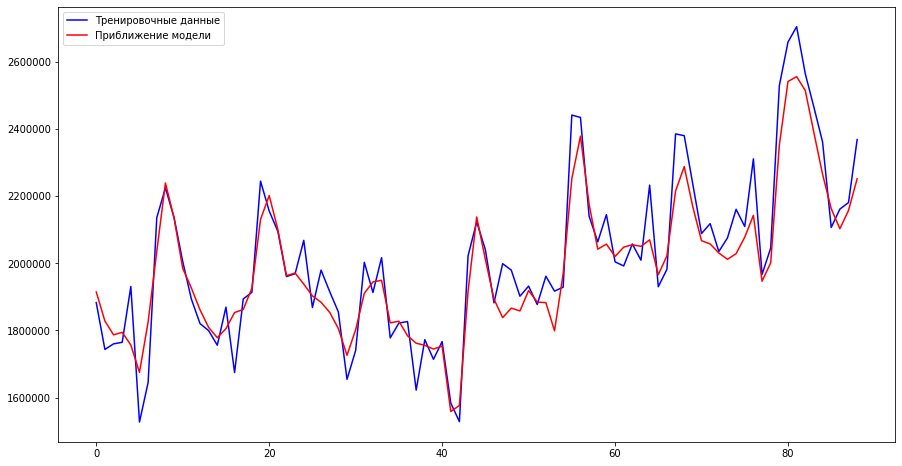

In [ ]:
plt.plot(df_train[window_size:, 1], c='b')
plt.plot(tmp[:-1, 1], c='r')
plt.legend(['Тренировочные данные', 'Приближение модели'])
plt.show()

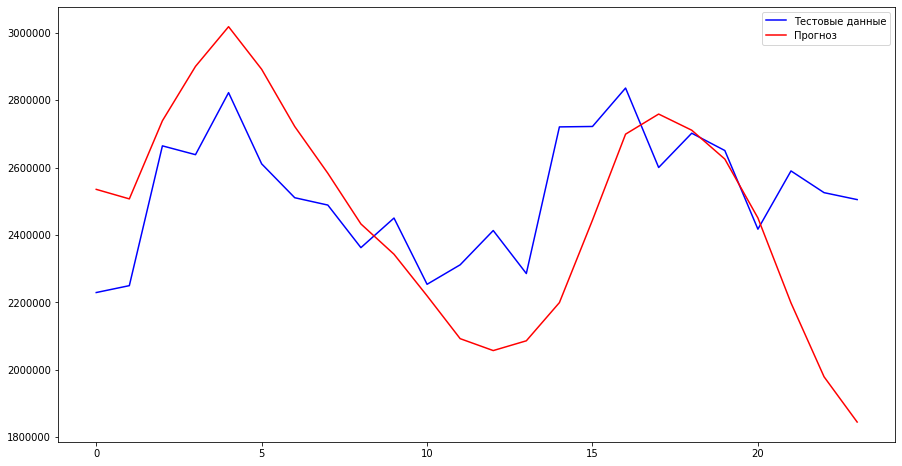

In [ ]:
plt.plot(df_test[:, 1], c='b')
plt.plot(df_pred[:, 1], c='r')
plt.legend(['Тестовые данные', 'Прогноз'])
plt.show()

По графикам видно, модель как-то научилась определять закономерности по тренировочным данным, и даже правильно определила расположение точек экстремумов при прогнозировании. Но такую оценку назвать хорошей, при условии оценки моделью SARIMAX сложно.

С другой стороны данная модель одновременно предсказывать 4 ряда:
 - Внутренние перевозки
 - Экспорт
 - Импорт
 - Транзит

 Модель SARIMAX же способна пронгозировать только какой-то один ряд.